In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from gensim.models import Word2Vec
from gensim.models import doc2vec
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem.snowball import SnowballStemmer
from string import punctuation
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split

In [2]:
def count(text):
    return len(text.split())
def delta_score(i, k):
    return abs(i-k)

In [3]:
swords = stopwords.words('russian')

In [4]:
stem = SnowballStemmer('russian')

In [5]:
df = pd.read_csv('./wb_school_task_2.csv.gzip', compression='gzip')

In [6]:
df.head()

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.0,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.7,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.0,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.0,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.0,6,4,5.000000,26,33,0


In [7]:
df['w_count'] = df.text.apply(count)
df['d_score'] = df.apply(lambda x: delta_score(x.f3, x.f6), axis=1)

In [8]:
text = df.text

In [9]:
text[0]

'Хотела купить на замену старых,по итогу эти  ужаснотупые ,не удобные ,рвут кутикулу ,а не режут.'

# Первичная обработка

In [10]:
tokenized_sw_p = pd.Series([nltk.word_tokenize(text[i], language='russian') for i in range(0, len(text))])

In [11]:
tokenized_sw_p.head()

0    [Хотела, купить, на, замену, старых, ,, по, ит...
1    [Запах, по, сравнению, с, обычным, DOVE, никак...
2            [Кабель, подошёл, ,, хорошо, работает, .]
3    [Восторг, !, Очень, приятный, аромат, ,, держи...
4    [Визуально, все, хорошо, ., Не, пробовали, ., ...
dtype: object

In [12]:
stemmed = []
for i in range(0, len(tokenized_sw_p)):
    stemmed.append([stem.stem(token) for token in tokenized_sw_p[i] if token not in swords and token not in punctuation])
stemmed = pd.Series(stemmed)

In [13]:
del tokenized_sw_p
del text

In [14]:
for i in range(0, len(stemmed)):
    stemmed[i] = " ".join(stemmed[i])

In [15]:
stemmed_tok = pd.Series([nltk.word_tokenize(stemmed[i], language='russian') for i in range(0, len(stemmed))])

In [16]:
df.label[1]

1

In [17]:
stemmed_tag=[]
for i in range(0, len(stemmed_tok)):
    stemmed_tag.append(doc2vec.TaggedDocument(stemmed_tok[i], [i]))

In [18]:
wvec = Word2Vec(vector_size=100, min_count=1, workers = -1)

In [19]:
wvec.build_vocab(stemmed_tok)

In [20]:
wvec.train(stemmed_tok, total_examples=wvec.corpus_count, epochs=30)

(0, 0)

In [21]:
docvec = doc2vec.Doc2Vec(vector_size=100, min_count=1, workers = -1)

In [22]:
docvec.build_vocab(stemmed_tag)

In [23]:
docvec.train(stemmed_tag, total_examples=docvec.corpus_count, epochs=30)

In [24]:
av=[]
for i in range(0, len(stemmed_tok)):
    l = np.array([wvec.wv[tok] for tok in stemmed_tok[i]])
    av.append((np.average(a=l,  axis = 1, weights=docvec[i])))
av = pd.Series(av) 

In [25]:
av

0       [0.006501248, -0.036276843, -0.007388494, -0.0...
1       [-0.0074324375, -0.00013321558, 0.0023792938, ...
2                 [-0.39994472, -0.10498576, -0.05326255]
3       [0.008655487, -0.005591501, -0.0022221394, 0.0...
4       [0.026074508, 0.00541414, -0.034570817, 0.0017...
                              ...                        
3118    [0.0014307552, -0.0033318643, -0.0070807342, -...
3119    [0.010798217, -0.022032978, 0.026537852, 0.014...
3120    [0.01548819, -0.0035458382, -0.004728016, 0.00...
3121    [0.010622692, 0.2379645, 0.075829595, 0.073439...
3122    [-0.05496994, 0.06809626, 0.09177352, -0.06670...
Length: 3123, dtype: object

In [26]:
X = [[]]*len(stemmed_tok)
for i in range(0, len(stemmed_tok)):
    X[i]= np.append(X[i], av[i].min())
    X[i]= np.append(X[i], av[i].max())

In [27]:
X[0]

array([-0.03627684,  0.02866629])

In [28]:
del av

In [29]:
y = df.label

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

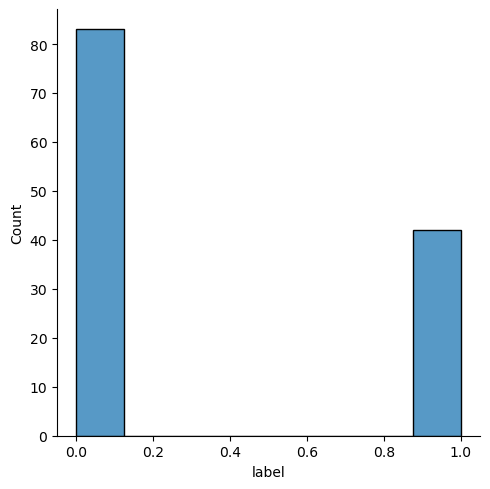

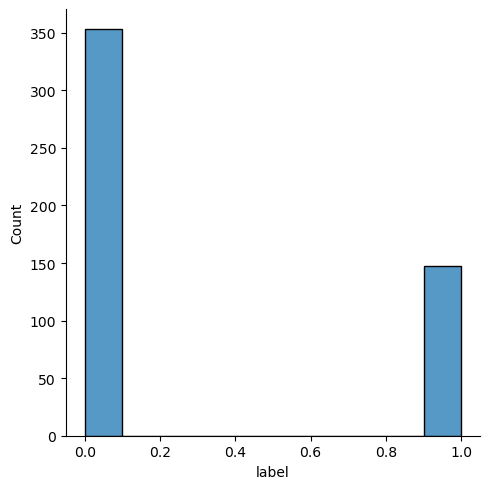

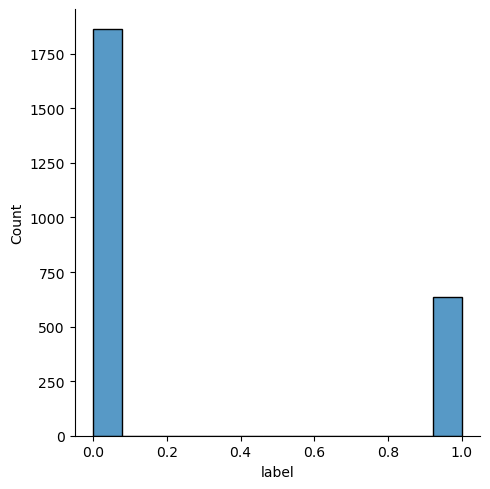

In [31]:
sns.displot(y_val)
sns.displot(y_test)
sns.displot(y_train)

In [32]:
clf = LogisticRegression()

In [33]:
clf.fit(X_train, y_train)

LogisticRegression()

In [34]:
y_pred = clf.predict(X_test)

In [35]:
cf_mx = confusion_matrix(y_test, y_pred)

<Axes: >

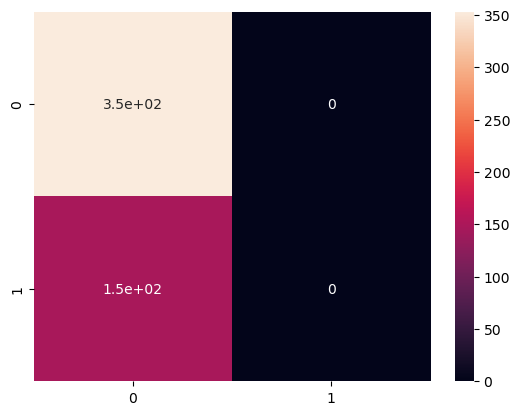

In [36]:
sns.heatmap(pd.DataFrame(cf_mx), annot=True)

In [37]:
X=[]
for i in range(0, len(stemmed_tok)):
    X.append(docvec[i])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

In [39]:
clf_d = LogisticRegression()

In [40]:
clf_d.fit(X_train, y_train)

LogisticRegression()

In [41]:
y_pred = clf_d.predict(X_test)

In [42]:
cf_mx_d = confusion_matrix(y_test, y_pred)

<Axes: >

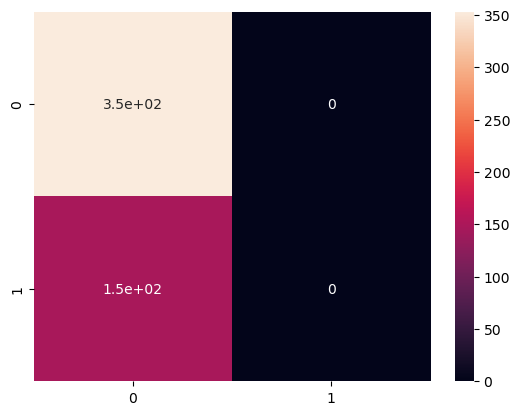

In [43]:
sns.heatmap(pd.DataFrame(cf_mx_d), annot=True)

In [44]:
X=df[['w_count','d_score']]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)

In [46]:
clf_s = LogisticRegression()

In [47]:
clf_s.fit(X_train, y_train)

LogisticRegression()

In [49]:
y_pred = clf_s.predict(X_test)

In [50]:
cf_mx_s = confusion_matrix(y_test, y_pred)

<Axes: >

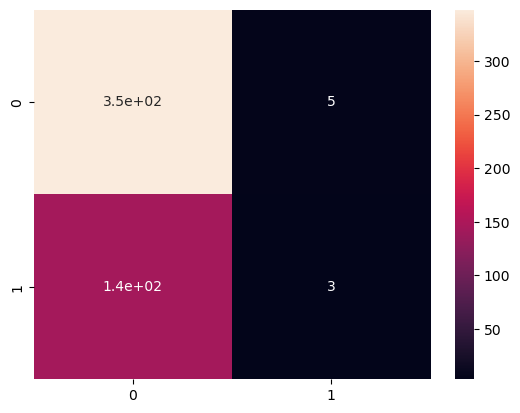

In [51]:
sns.heatmap(pd.DataFrame(cf_mx_s), annot=True)